<a href="https://colab.research.google.com/github/yaobviously/perkins_temp/blob/main/perkins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import xgboost

In [87]:
pop_csv = '/content/drive/MyDrive/Temperature_Perkins/Population Data.csv'
temp_csv = '/content/drive/MyDrive/Temperature_Perkins/Temperature Data.csv'

In [88]:
def load_transform_data():
  """
  Preparing the temperature and population datasets for visualization and 
  analysis
  """

  temp_df = pd.read_csv(temp_csv, parse_dates=['location_date'])

  pop_df = pd.read_csv(pop_csv)

  # case normalizing pop columns
  pop_df.columns = pop_df.columns.str.lower()

  # dropping redundant columns
  col_drop = ['country_name', 'country_code', 'continent']
  temp_df = temp_df.drop(col_drop, axis=1)

  # renaming columns - celsius will be indicated in viz
  temp_df = temp_df.rename(columns={'temp_mean_c': 'mean_temp',
                                    'temp_min_c' : 'min_temp',
                                    'temp_max_c' : 'max_temp'})

  # making it easier to merge with pop df
  temp_df['name'] = [x.split('/')[0] for x in temp_df['name']]
  temp_df = temp_df.rename(columns={'name':'city'})

  # creating a city dictionary to find matching city pops. i'm replacing 
  # Albany with Syracuse because it seems relatively close in terms of pop (for weighting)
  # transparent hack - could easily hard code the population using google.com, 
  # but i'm using ONLY dataset provided + rough knowledge of Albany pop.

  city_dict = {'St Louis' : 'St. Louis', 'NYC' : 'New York', "Chicago O'Hare" : 'Chicago',
               'Covington': 'Cincinnati', 'Wash DC' : 'Washington', 'Windsor Locks' : 'Hartford',
               'Albany' : 'Syracuse'
               }
  temp_df['city'] = temp_df['city'].map(city_dict).fillna(temp_df['city'])

  reverse_dict = {v:k for k,v in city_dict.items()}
  
  # merging the dataframes and fixing the Albany hack above

  merged_df = pd.merge(temp_df, pop_df, how='left', on='city')
  merged_df = merged_df.set_index('location_date').sort_index()
  
  merged_df['city'] = merged_df['city'].map(reverse_dict).fillna(merged_df['city'])
  merged_df['city'] = merged_df['city'].replace('Wash DC', 'Washington (Dulles)')
  # creating a function to find the dates with missing values for each
  # station and then appending all of those dates to the main dataframe

  days = merged_df.index.unique()

  def find_miss_days(station_code = 'KLIT'):

    df_ = merged_df[merged_df['station_code'] == station_code]

    indexes = set(df_.index)
    dates_missing = set(days).difference(indexes)

    val_dict = {'city' : df_['city'][0],
                'station_code' : station_code,
                'state' : df_['state'][0],
                'population' : df_['population'][0],
                'lon' : df_['lon'][0],
                'lat' : df_['lat'][0]
                }

    new_df = pd.DataFrame(val_dict, index=tuple(dates_missing))

    return new_df

  df_append = [find_miss_days(code) for code in merged_df.station_code.unique()]
  df_concat = pd.concat(df_append)

  df = merged_df.append(df_concat)

  df = df.sort_index()

  # creatin a multilevel index to ensure unique index values for all rows
  df = df.set_index('station_code', append=True)
  
  # extracting month/year from index to compute averages for each 
  # location
  df['month'] = pd.DatetimeIndex(df.index.get_level_values(0)).month
  df['year'] = pd.DatetimeIndex(df.index.get_level_values(0)).year

  # computing rolling averages for the purpose of imputation. for predictive 
  # modelling i would utilize shift()
  
  df['7day_rolling_mean'] = df.groupby(df.index.get_level_values(1))['mean_temp'].transform(lambda x: x.rolling(7, min_periods=3).mean().fillna(method='ffill').fillna(method='bfill'))
  df['7day_rolling_max'] = df.groupby(df.index.get_level_values(1))['max_temp'].transform(lambda x: x.rolling(7, min_periods=3).mean().fillna(method='ffill').fillna(method='bfill'))
  df['7day_rolling_min'] = df.groupby(df.index.get_level_values(1))['min_temp'].transform(lambda x: x.rolling(7, min_periods=3).mean().fillna(method='ffill').fillna(method='bfill'))
  
  df['30day_rolling_mean'] = df.groupby(df.index.get_level_values(1))['mean_temp'].transform(lambda x: x.rolling(30, min_periods=5).mean().fillna(method='ffill').fillna(method='bfill'))
  df['90day_rolling_mean'] = df.groupby(df.index.get_level_values(1))['mean_temp'].transform(lambda x: x.rolling(90, min_periods=5).mean().fillna(method='ffill').fillna(method='bfill'))
  
  # computing cumulative expanding averages for this dataset
  df['monthly_average'] = df.groupby([df.index.get_level_values(1), 'month'])['mean_temp'].transform(lambda x: x.expanding().mean().fillna(method='bfill'))
  
  # flagging rows that will have imputed daily temperature values
  df['imputed_mean'] = [1 if pd.isna(mean) else 0 for mean in df['mean_temp']]
  
  # filling in missing values with rolling average
  df['mean_temp'] = [y if pd.isna(x) else x for x, y in zip(df['mean_temp'], df['7day_rolling_mean'])]
  df['max_temp'] = [y if pd.isna(x) else x for x, y in zip(df['max_temp'], df['7day_rolling_max'])]
  df['min_temp'] = [y if pd.isna(x) else x for x, y in zip(df['min_temp'], df['7day_rolling_min'])]  
  
  # rounding and fixing columns
  df['city_full'] = [", ".join(x) for x in zip(df['city'], df['state'])]
  drop_cols = ['city', 'state', 'year']
  df = df.drop(drop_cols, axis=1)
  df = df.round(2)  
  
  return df


In [89]:
df = load_transform_data()

print("The shape of the new dataframe is:", df.shape)

The shape of the new dataframe is: (94353, 15)


In [52]:
def plot_city(city = 'Sacramento', duration='W'):
  """
  A simple plotting function that takes a city and a duration and displays a graph
  of the average of the mean temp, max temp, and min temp over that time span

  Parameters
  ----------
    City : str
    duration: str ("D", "W", "M", "A")

  Returns
  -------
    Graph: matplot plot
  """

  cols = ['mean_temp', 'max_temp', 'min_temp']

  df_ = df[df['city'] == city]

  fig, ax = 

  return df_[cols].resample(duration).mean().plot(figsize=(24,5), grid=True, legend=True);

SyntaxError: ignored

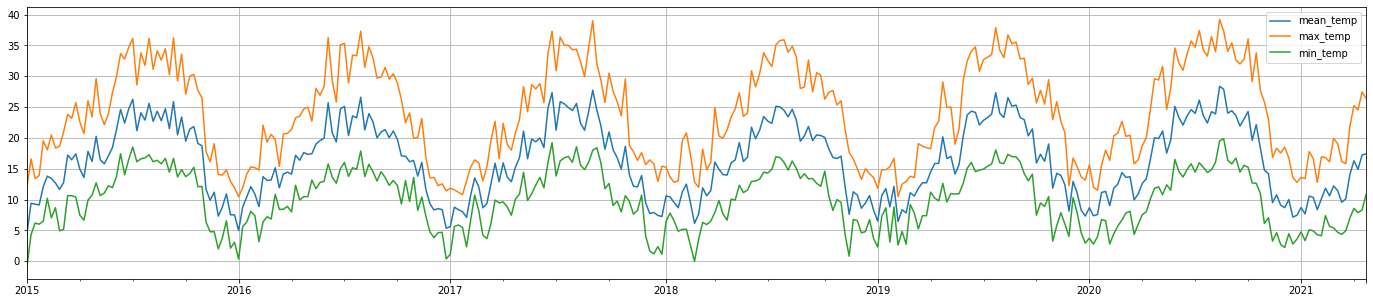

In [ ]:
# showing that it works

plot_city()

In [ ]:
def estimate_pop(date = '2020-05-01', temp=25):
  """
  Takes a date and a temperature and tells you how many residents in the 
  dataset experienced temperatures above the entered value on that date

  Parameters
  ----------
    date: datetime
    temp: int

  Returns
  -------
    total population: float
  """

  df_ = df[(df.index == date) & (df['max_temp'] >= temp)]
  return df_.population.sum()


In [ ]:
print(f"On March 22nd, 2018 {estimate_pop(date='2018-03-22', temp=21)} experienced temperatures above 21C")

On March 22nd, 2018 5818554.0 experienced temperatures above 21C
